<a href="https://colab.research.google.com/github/trismegisto78/romeo/blob/master/Copy_of_testBidirLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import numpy as np
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten,CuDNNLSTM,Reshape,Conv2D,GaussianNoise,Dropout,Input
from keras.initializers import glorot_uniform
from keras.regularizers import Regularizer
from keras import regularizers
from keras.models import Model


Using TensorFlow backend.


In [0]:
!git clone https://github.com/trismegisto78/romeo

MOUNT GOOGLE DRIVE

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
with open('/content/gdrive/My Drive/strMacd2004.csv', 'r') as f:
  lerighe = f.read().split('\n')
del lerighe[0]

In [24]:
#create main data array with float values
righe_file=[]
valoriOriginali = []
for k in range(0,350000) :
  righe_file.append( np.around((float(lerighe[k+1].split(";")[1]) -float(lerighe[k].split(";")[1]))*100000,0) )
  valoriOriginali.append(float(lerighe[k].split(";")[1]))
print(righe_file[0])




10.0


In [25]:
#find max and min
ilMax = max(righe_file)
ilMin = min(righe_file)


delta = ilMax-ilMin


print('MAX ', ilMax )
print('MIN ', ilMin )
print('delta ', delta )

MAX  1590.0
MIN  -1270.0
delta  2860.0


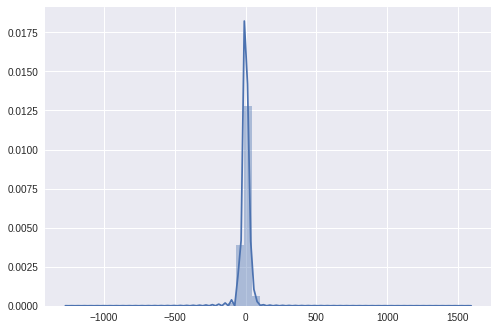

In [26]:

#distribution
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)

sns.distplot(righe_file);

#unique, counts = np.unique(righe_file, return_counts=True)


 #valoriMain = np.asarray((unique, counts) )
#(pd.value_counts(unique) ).plot.bar( ec="orange")



In [0]:
# create a sequence classification instance
def get_sequence(dataset_array):
  idx = np.random.randint(0,len(dataset_array)-130  )
  X,y = get_sequence_from_idx(dataset_array,idx)
  return X,y

def get_sequence_from_idx(dataset_array,idx):
  
  X = np.zeros(n_timesteps)
  Y = np.zeros(1)
   
  
  for k in range(idx,idx+n_timesteps ):
    #value=normValue(dataset_array[k])
    value=dataset_array[k]
    X[k-idx]=value
    
  #finalValue=normValue(dataset_array[idx+130])
  lastVlue = valoriOriginali[idx+100]
  finalValue= valoriOriginali[idx+130]

  if finalValue<(lastVlue-0.00050):
    Y[0]=1.0
  else:
    Y[0]=0.0
  
  X = X.reshape(n_timesteps,1)
  Y = Y.reshape(1)
  return X, Y

def get_a_batch(batchSize,data_set):
  totexamples = batchSize
  xInput = np.zeros( (totexamples,n_timesteps,1) )
  target = np.zeros( (totexamples,1) )
  for k in range(0,totexamples):
    X,y = get_sequence(data_set)
    xInput[k] = X
    target[k] = y
  
  return xInput,target

def get_simple_random_batch(batchSize,data_set):
  idx = np.random.randint(0,len(data_set),batchSize  )
  fullBatch = data_set[idx]
  
  xInput = np.zeros( (batchSize,n_timesteps,1) )
  target = np.zeros( (batchSize,1) )
  
  for k in range( len(fullBatch)  ):
    xInput[k] = fullBatch[k][0]
    target[k] = fullBatch[k][1]
  
  return xInput,target

def get_simple_all_dataset(data_set):
  
  xInput = np.zeros( (len(data_set),n_timesteps,1) )
  target = np.zeros( (len(data_set),1) )
  
  for k in range( len(data_set)  ):
    xInput[k] = data_set[k][0]
    target[k] = data_set[k][1]
  
  return xInput,target

def getAllDataSet(data_set):
  totexamples = len(data_set)-130
  xInput = np.zeros( (totexamples,n_timesteps,1) )
  target = np.zeros( (totexamples,1) )
  listone = []
  for k in range(0,totexamples):
    X,y = get_sequence_from_idx(data_set,k)
    ilMax = np.max(X)
    ilMin = np.min(X)
    
    X = (X-ilMin)/(ilMax-ilMin)
#    xInput[k] = X
#    target[k] = y
    if X.max()<=500 or X.min()>=-500:
      listone.append([X/500,y])
    if k % 100000 ==0 :
      print('generate %d dataset items ' % k)
  return listone#xInput,target 


In [0]:
def normValue(theValue):
  return (float(theValue)-ilMin)/delta


In [29]:
from sklearn.model_selection import train_test_split

n_timesteps = 100

allDataset = getAllDataSet(righe_file)


train, validation = train_test_split(allDataset,shuffle=False)

print("TRAIN LEN ",len(train) )
print("validation LEN ",len(validation) )


generate 0 dataset items 
generate 100000 dataset items 
generate 200000 dataset items 
generate 300000 dataset items 
TRAIN LEN  262402
validation LEN  87468


In [0]:
#train[0].head()
array_train = np.asarray(train )
array_val = np.asarray(validation )



In [31]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [32]:
import keras as keras

model = Sequential()
model.add(Bidirectional(CuDNNLSTM(n_timesteps, return_sequences=True), 
                        input_shape=(n_timesteps, 1), name='inputBIDI'))
model.add(Bidirectional(CuDNNLSTM(512, return_sequences=True)))
model.add(TimeDistributed(Dense(512, activation='tanh')))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid')  ) 

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputBIDI (Bidirectional)    (None, 100, 200)          82400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 1024)         2924544   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 512)          524800    
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51201     
Total params: 3,582,945
Trainable params: 3,582,945
Non-trainable params: 0
_________________________________________________________________


In [0]:
samplePos=0
# train LSTM




np.random.shuffle(array_val)
xInput,target = get_simple_all_dataset(array_val)


import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

for epoch in range(10000000):
 
  X,y = get_simple_random_batch(64,array_train )
  resTrain = model.train_on_batch(X,y)

    
  if(epoch % 100 == 0):
    model.save('my_model.h5') 
    print('Apprendimento epoch->',epoch,' ',resTrain)
    
  if(epoch % 200 == 0):
    model.save('my_model.h5') 
    
  if(epoch % 300 == 0 and not epoch == 0 ):
    model.save('my_model.h5') 
    totexamples = 1000
    resulto = model.evaluate(xInput, target, verbose=1,batch_size=128)

    print('Eseguo validazione %.2f%%'%(resulto[1]*100), '>>>>>',resulto  )
    print('')

  
# evaluate LSTM



Found GPU at: /device:GPU:0
Apprendimento epoch-> 0   [0.5265362, 0.78125]
Apprendimento epoch-> 100   [0.5446014, 0.765625]
Apprendimento epoch-> 200   [0.58166325, 0.734375]
